# **Real-Time Hand Gesture Recognition — Graduation Project (AMIT)**

Student: Mohammed Walid

Project: Real-Time Hand Gesture Recognition using two ML pipelines

Goal: Build a robust system that recognizes hand gestures (classes 1–5) in real-time from webcam.

## **What I will deliver**

This notebook implements two different pipelines (Option A and Option B), trains them, evaluates them, and compares them like a professional AI engineer:

### **Option A (Deep Learning — GPU)**

YOLOv8 Image Classification (Ultralytics)

Train a CNN-based classifier on cropped-hand images (train/val/test).

Benefit: powerful end-to-end learning, strong accuracy if dataset is good.

Runs on GPU for faster training.

Option B (Classical ML — CPU)

MediaPipe Hand Landmarks → ML Classifier (SVM / RandomForest)

Extract 21 hand landmarks (x,y,z) from each image.

Train a classifier on those numeric features.

Benefit: fast inference, interpretable, often works well with small datasets.

**Why two options?**

This provides a realistic engineering comparison:

accuracy vs speed

robustness vs interpretability

training cost vs deployment simplicity

**Imports & global settings**

In [2]:
import os, glob, json, time, random, shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

**Step 1 — Reproducibility & environment checks**

I set random seeds for reproducibility and confirm GPU (CUDA) is available.
This is a professional habit so results can be reproduced.

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


My dataset is a **cropped-hand dataset** saved locally after MediaPipe cropping.
Expected folder structure (classification):

DATA_ROOT/

train/

1/

2/

3/

4/

5/

valid/ (or val/)

1..5

test/

1..5

I validate it before training.

In [4]:
DATA_ROOT = Path(r"C:\Users\mohamed harbe\Downloads\hand_dataset_v1_cropped")  # <-- EDIT if needed

train_dir = DATA_ROOT / "train"
valid_dir = DATA_ROOT / "valid"
if not valid_dir.exists():
    valid_dir = DATA_ROOT / "val"
test_dir  = DATA_ROOT / "test"

assert train_dir.exists(), f"Missing: {train_dir}"
assert valid_dir.exists(), f"Missing: {valid_dir}"
assert test_dir.exists(),  f"Missing: {test_dir}"

classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
print("Classes:", classes)
print("Train:", train_dir)
print("Valid:", valid_dir)
print("Test :", test_dir)

Classes: ['1', '2', '3', '4', '5']
Train: C:\Users\mohamed harbe\Downloads\hand_dataset_v1_cropped\train
Valid: C:\Users\mohamed harbe\Downloads\hand_dataset_v1_cropped\valid
Test : C:\Users\mohamed harbe\Downloads\hand_dataset_v1_cropped\test


**Step 3 — Dataset statistics**

I compute how many images per split and per class to detect imbalance early.

In [5]:
def count_images_by_class(split_dir: Path):
    out = {}
    for c in classes:
        p = split_dir / c
        out[c] = len(list(p.glob("*.jpg"))) + len(list(p.glob("*.png"))) + len(list(p.glob("*.jpeg")))
    return out

train_counts = count_images_by_class(train_dir)
valid_counts = count_images_by_class(valid_dir)
test_counts  = count_images_by_class(test_dir)

df_counts = pd.DataFrame({
    "train": train_counts,
    "valid": valid_counts,
    "test":  test_counts
}).fillna(0).astype(int)

df_counts["total"] = df_counts.sum(axis=1)
df_counts.loc["ALL"] = df_counts.sum(axis=0)
df_counts

,train,valid,test,total
1,60,21,7,88
2,57,14,11,82
3,61,16,12,89
4,61,21,7,89
5,63,13,7,83
ALL,302,85,44,431


**Step 4 — Visualize class balance**

This is an engineering sanity check: if one class dominates, models may be biased.

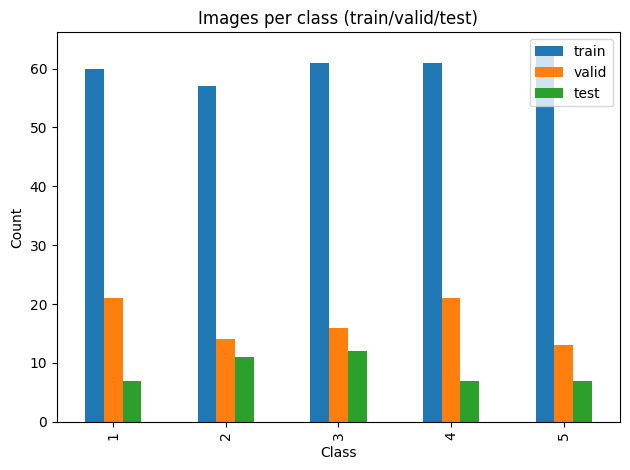

In [6]:
df_plot = df_counts.drop(index="ALL")
df_plot[["train","valid","test"]].plot(kind="bar")
plt.title("Images per class (train/valid/test)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

**Step 5 — Visual sample inspection**

I preview random images from each class to verify that:

crop is correct (hand-only)

labels match gesture

quality and lighting diversity exist

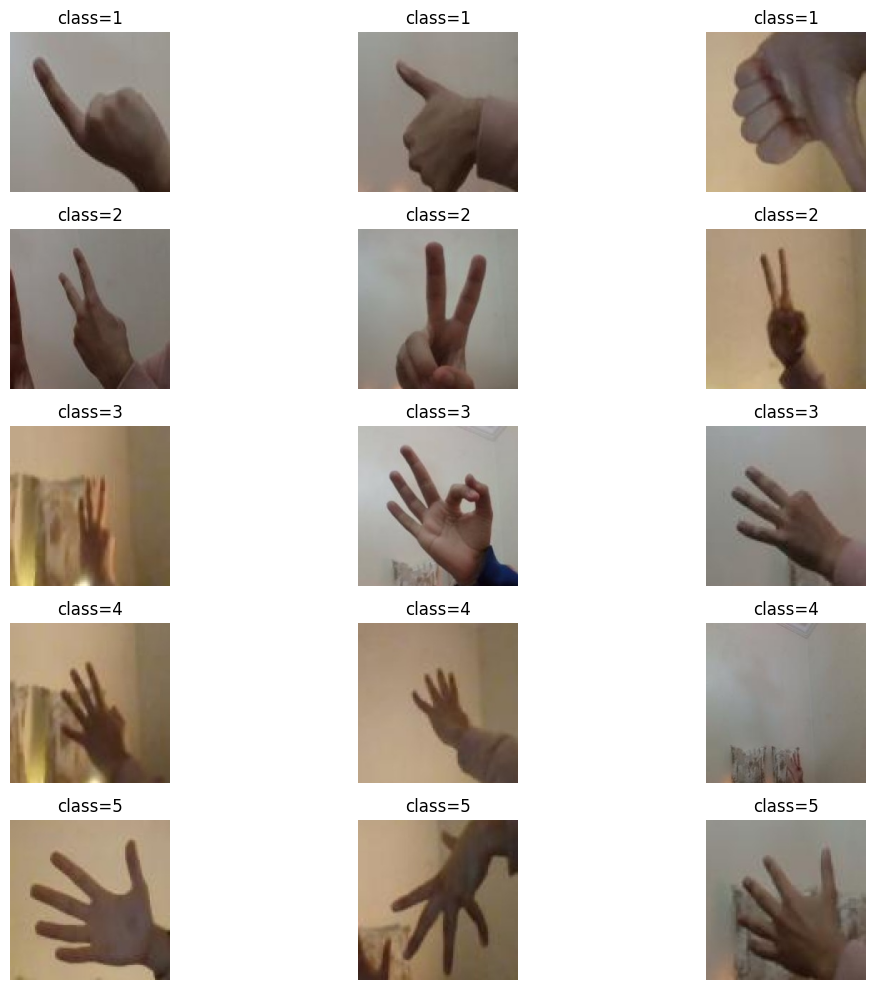

In [7]:
def show_samples(split_dir: Path, n_per_class=3):
    plt.figure(figsize=(12, 10))
    idx = 1
    for c in classes:
        imgs = list((split_dir / c).glob("*.jpg")) + list((split_dir / c).glob("*.png")) + list((split_dir / c).glob("*.jpeg"))
        random.shuffle(imgs)
        for p in imgs[:n_per_class]:
            img = Image.open(p).convert("RGB")
            plt.subplot(len(classes), n_per_class, idx)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"class={c}")
            idx += 1
    plt.tight_layout()
    plt.show()

show_samples(train_dir, n_per_class=3)

============================================================

# **✅ OPTION A — YOLOv8 CLASSIFICATION (GPU)**

============================================================

## Option A — Deep Learning (GPU): YOLOv8 Image Classification

This option trains a CNN classifier on cropped hand images using Ultralytics (YOLOv8 classification).
I use a pretrained backbone then fine-tune on my dataset.

**Deliverables from Option A:**

trained weights

training curves

evaluation metrics on test set

confusion matrix

real-time webcam inference script

**Install / Import Ultralytics**

Ultralytics is used for training and inference for classification.

In [8]:
from ultralytics import YOLO

In [33]:
# OUTPUT folder for experiments
RUNS_DIR = Path("runs_amIT")
RUNS_DIR.mkdir(exist_ok=True)

model_a = YOLO("yolo26n-cls.pt")

results_a = model_a.train(
    data=str(DATA_ROOT),       # expects train/val/test in this folder
    imgsz=224,
    epochs=50,
    batch=32,
    device=0,                  # GPU
    project=str(RUNS_DIR),
    name="OptionA_yolo26n_cls",
    seed=SEED,
    workers=4
)

Ultralytics 8.4.14  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\mohamed harbe\Downloads\hand_dataset_v1_cropped, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=OptionA_YOLOv8n_cls2, nbs=64, nms=False, opset=None, optimiz

**Evaluate on test split**

After training, I evaluate on test images and report:

Accuracy

Macro F1

Confusion matrix

Classification report

In [35]:
from pathlib import Path

# Try common Ultralytics default locations
candidates = [
    Path.home() / "runs" / "classify" / "runs_amIT" / "OptionA_YOLOv8n_cls" / "weights" / "best.pt",
    Path(r"C:\Users\mohamed harbe\runs\classify\runs_amIT\OptionA_yolo26n_cls\weights\best.pt"),
]

best_weights = None
for p in candidates:
    if p.exists():
        best_weights = p
        break

# If still not found, search recursively (safe and reliable)
if best_weights is None:
    roots = [Path.home() / "runs", Path.cwd()]
    found = []
    for root in roots:
        if root.exists():
            found += list(root.rglob("best.pt"))

    # Prefer the one inside your run name
    for f in found:
        if "OptionA_yolo26n_cls" in str(f):
            best_weights = f
            break

    # If still none, pick most recent
    if best_weights is None and found:
        best_weights = max(found, key=lambda x: x.stat().st_mtime)

assert best_weights is not None and best_weights.exists(), "❌ Could not locate best.pt. Check your runs folder."

print("✅ Using best weights:", best_weights)

✅ Using best weights: C:\Users\mohamed harbe\runs\classify\runs_amIT\OptionA_YOLOv8n_cls\weights\best.pt


In [36]:
from pathlib import Path
print("CWD:", Path.cwd())
print("Home:", Path.home())
print("best_weights currently =", best_weights)

CWD: C:\Users\mohamed harbe
Home: C:\Users\mohamed harbe
best_weights currently = C:\Users\mohamed harbe\runs\classify\runs_amIT\OptionA_YOLOv8n_cls\weights\best.pt


In [37]:
from pathlib import Path

best_weights = Path(r"C:\Users\mohamed harbe\runs\classify\runs_amIT\OptionA_YOLOv8n_cls\weights\best.pt")
assert best_weights.exists(), f"Still not found: {best_weights}"

print("✅ Found:", best_weights)

✅ Found: C:\Users\mohamed harbe\runs\classify\runs_amIT\OptionA_YOLOv8n_cls\weights\best.pt


In [38]:
from ultralytics import YOLO
model_a_best = YOLO(str(best_weights))

✅ Option A Accuracy: 0.9772727272727273
✅ Option A Macro F1 : 0.9779710144927536

Classification report:

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         7
           2     1.0000    1.0000    1.0000        11
           3     1.0000    0.9167    0.9565        12
           4     1.0000    1.0000    1.0000         7
           5     0.8750    1.0000    0.9333         7

    accuracy                         0.9773        44
   macro avg     0.9750    0.9833    0.9780        44
weighted avg     0.9801    0.9773    0.9775        44



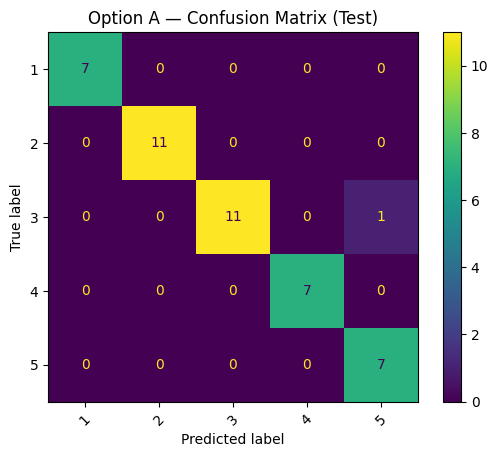

In [39]:
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_a_best = YOLO(str(best_weights))

# Collect test image paths + labels
X_test, y_test = [], []
for c in classes:
    for p in (test_dir / c).glob("*.*"):
        if p.suffix.lower() in [".jpg",".jpeg",".png",".webp"]:
            X_test.append(str(p))
            y_test.append(c)

preds = model_a_best.predict(X_test, imgsz=224, device=0, verbose=False)

y_pred = []
for r in preds:
    top1 = int(r.probs.top1)
    y_pred.append(classes[top1])

acc_a = accuracy_score(y_test, y_pred)
f1_a  = f1_score(y_test, y_pred, average="macro")

print("✅ Option A Accuracy:", acc_a)
print("✅ Option A Macro F1 :", f1_a)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))

cm_a = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.title("Option A — Confusion Matrix (Test)")
plt.show()

**Real-time webcam demo (Option A)**

This runs your trained classifier on live webcam frames.

Run this cell locally (not on limited environments).
Press q to quit.

In [40]:
import cv2

cap = cv2.VideoCapture(0)
assert cap.isOpened(), "Could not open webcam"

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR to RGB for model
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb)

    # Predict
    res = model_a_best.predict(pil_img, imgsz=224, device=0, verbose=False)[0]
    pred_idx = int(res.probs.top1)
    pred_label = classes[pred_idx]
    conf = float(res.probs.top1conf)

    # Overlay text
    cv2.putText(frame, f"A: {pred_label} ({conf:.2f})", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    cv2.imshow("Option A - YOLOv8 Classifier", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

============================================================

# **✅ OPTION B — MEDIAPIPE LANDMARKS + CLASSIFIER**

============================================================

## **Option B — Classical ML: MediaPipe Hand Landmarks → ML Classifier**

This option extracts 21 hand landmarks per image and trains a classifier on numeric features.

**Pipeline:**

Load image

Run MediaPipe Hands to get landmarks

Convert landmarks to feature vector (x,y,z for each point)

Train model (SVM and/or RandomForest)

Evaluate on test set

**Install / Import MediaPipe**

You already used MediaPipe for cropping, so this will run in the same environment.

In [21]:
import mediapipe as mp
mp_hands = mp.solutions.hands

**Feature extraction function**

I create a feature vector of length 63 (21 landmarks × 3 coords).
To make features robust to position/scale, I normalize by:

shifting so wrist landmark becomes origin

scaling by max distance

This improves generalization.

In [22]:
def landmarks_to_feature(hand_landmarks):
    pts = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark], dtype=np.float32)  # (21,3)

    # Normalize: translate so wrist (0) is origin
    pts = pts - pts[0:1, :]

    # Scale normalization
    scale = np.linalg.norm(pts, axis=1).max()
    if scale > 1e-6:
        pts = pts / scale

    return pts.flatten()  # (63,)

**Build dataset features (train/valid/test)**

I extract landmarks for all images.
If a hand is not detected, I skip that image (or you can keep fallback logic).

In [23]:
import cv2
from tqdm import tqdm

def extract_split_features(split_dir: Path):
    X, y, paths = [], [], []
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        for c in classes:
            img_paths = list((split_dir / c).glob("*.*"))
            for p in tqdm(img_paths, desc=f"Extract {split_dir.name}/{c}", leave=False):
                if p.suffix.lower() not in [".jpg",".jpeg",".png",".webp"]:
                    continue
                img_bgr = cv2.imread(str(p))
                if img_bgr is None:
                    continue
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                res = hands.process(img_rgb)
                if not res.multi_hand_landmarks:
                    continue  # skip if no hand detected

                feat = landmarks_to_feature(res.multi_hand_landmarks[0])
                X.append(feat)
                y.append(c)
                paths.append(str(p))
    return np.array(X), np.array(y), paths

X_train_b, y_train_b, _ = extract_split_features(train_dir)
X_valid_b, y_valid_b, _ = extract_split_features(valid_dir)
X_test_b,  y_test_b,  _ = extract_split_features(test_dir)

print("Option B feature shapes:")
print("Train:", X_train_b.shape, y_train_b.shape)
print("Valid:", X_valid_b.shape, y_valid_b.shape)
print("Test :", X_test_b.shape,  y_test_b.shape)

Option B feature shapes:
Train: (207, 63) (207,)
Valid: (62, 63) (62,)
Test : (24, 63) (24,)


**Train classifiers (Option B)**

I train two models:

RandomForest (good baseline)

SVM (often strong for landmark features)

I select the best based on validation macro-F1.

In [24]:
# Combine train + valid for tuning (more data for CV)
X_tune = np.vstack([X_train_b, X_valid_b])
y_tune = np.hstack([y_train_b, y_valid_b])

print("Tune set:", X_tune.shape, y_tune.shape)

Tune set: (269, 63) (269,)


In [25]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import loguniform, randint

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# ---- SVM pipeline (scaling is important) ----
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=SEED))
])

svm_dist = {
    "clf__C": loguniform(0.1, 50),
    "clf__gamma": loguniform(1e-4, 1e-1)
}

svm_search = RandomizedSearchCV(
    svm_pipe,
    param_distributions=svm_dist,
    n_iter=25,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

# ---- RandomForest ----
rf = RandomForestClassifier(class_weight="balanced", random_state=SEED)

rf_dist = {
    "n_estimators": randint(200, 900),
    "max_depth": [None] + list(range(4, 31, 2)),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

rf_search = RandomizedSearchCV(
    rf,
    param_distributions=rf_dist,
    n_iter=30,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

# Run searches
svm_search.fit(X_tune, y_tune)
rf_search.fit(X_tune, y_tune)

print("\n✅ Best SVM:", svm_search.best_params_)
print("✅ Best SVM CV Macro-F1:", svm_search.best_score_)

print("\n✅ Best RF:", rf_search.best_params_)
print("✅ Best RF CV Macro-F1:", rf_search.best_score_)

best_b = svm_search.best_estimator_ if svm_search.best_score_ >= rf_search.best_score_ else rf_search.best_estimator_
print("\n✅ Selected Option B model:", type(best_b).__name__)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best SVM: {'clf__C': np.float64(9.45430681953617), 'clf__gamma': np.float64(0.006251373574521752)}
✅ Best SVM CV Macro-F1: 0.8422765576515164

✅ Best RF: {'bootstrap': True, 'max_depth': 28, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 417}
✅ Best RF CV Macro-F1: 0.8180140735952854

✅ Selected Option B model: Pipeline


**Evaluate Option B on test set**

I compute accuracy, macro-F1, and confusion matrix on the test set.

In [26]:
y_pred_b = best_b.predict(X_test_b)

acc_b = accuracy_score(y_test_b, y_pred_b)
f1_b  = f1_score(y_test_b, y_pred_b, average="macro")

print("Option B Accuracy:", acc_b)
print("Option B Macro F1 :", f1_b)
print("\nClassification report:\n")
print(classification_report(y_test_b, y_pred_b, digits=4))

Option B Accuracy: 0.9166666666666666
Option B Macro F1 : 0.9252747252747253

Classification report:

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         1
           2     1.0000    0.7500    0.8571         4
           3     1.0000    0.8571    0.9231         7
           4     0.8571    1.0000    0.9231         6
           5     0.8571    1.0000    0.9231         6

    accuracy                         0.9167        24
   macro avg     0.9429    0.9214    0.9253        24
weighted avg     0.9286    0.9167    0.9153        24



**Confusion Matrix (Option B)**

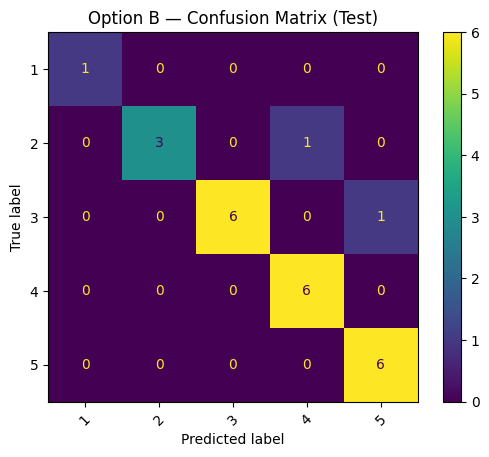

In [27]:
cm_b = confusion_matrix(y_test_b, y_pred_b, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.title("Option B — Confusion Matrix (Test)")
plt.show()

**Real-time webcam demo (Option B)**

This runs MediaPipe landmarks live and predicts gesture using the selected classical model.

Press q to quit.

In [28]:
cap = cv2.VideoCapture(0)
assert cap.isOpened(), "Could not open webcam"

with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(img_rgb)

        label_text = "B: no-hand"
        if res.multi_hand_landmarks:
            feat = landmarks_to_feature(res.multi_hand_landmarks[0]).reshape(1, -1)
            pred = best_b.predict(feat)[0]
            prob = np.max(best_b.predict_proba(feat))
            label_text = f"B: {pred} ({prob:.2f})"

            # Draw landmarks
            mp.solutions.drawing_utils.draw_landmarks(
                frame, res.multi_hand_landmarks[0], mp_hands.HAND_CONNECTIONS
            )

        cv2.putText(frame, label_text, (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

        cv2.imshow("Option B - MediaPipe Landmarks Classifier", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

cap.release()
cv2.destroyAllWindows()

============================================================

# ✅ COMPARISON + ENGINEERING CONCLUSION

============================================================

## **Option A vs Option B — Final Comparison**

I compare both options using:

Test Accuracy

Test Macro-F1

Practical deployment considerations (speed, dependencies)

In [29]:
comparison = pd.DataFrame([
    {"Option": "A (YOLOv8 classification - GPU)", "Accuracy": acc_a, "MacroF1": f1_a},
    {"Option": "B (MediaPipe landmarks + ML - CPU)", "Accuracy": acc_b, "MacroF1": f1_b},
])
comparison

,Option,Accuracy,MacroF1
0,A (YOLOv8 classification - GPU),0.977273,0.977971
1,B (MediaPipe landmarks + ML - CPU),0.916667,0.925275


**Engineering interpretation**


**Export artifacts for AMIT + GitHub**

I save:

metrics.json

best Option B model (joblib)

Option A weights path reference

requirements.txt

⚠️ I will NOT publish raw dataset on GitHub (privacy).
I will publish raw dataset + code + notebook + trained weights only.

In [30]:
import joblib

ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True)

# Save Option B model
joblib.dump(best_b, ARTIFACTS / "optionB_best_model.joblib")

# Save metrics
metrics = {
    "optionA": {"accuracy": float(acc_a), "macro_f1": float(f1_a), "best_weights": str(best_weights)},
    "optionB": {"accuracy": float(acc_b), "macro_f1": float(f1_b), "model": type(best_b).__name__}
}

with open(ARTIFACTS / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved to:", ARTIFACTS.resolve())
print(metrics)

Saved to: C:\Users\mohamed harbe\artifacts
{'optionA': {'accuracy': 0.9772727272727273, 'macro_f1': 0.9779710144927536, 'best_weights': 'C:\\Users\\mohamed harbe\\runs\\classify\\runs_amIT\\OptionA_YOLOv8n_cls\\weights\\best.pt'}, 'optionB': {'accuracy': 0.9166666666666666, 'macro_f1': 0.9252747252747253, 'model': 'Pipeline'}}


In [31]:
req = """
ultralytics
opencv-python
numpy
pandas
matplotlib
scikit-learn
mediapipe
tqdm
joblib
torch
torchvision
torchaudio
""".strip()

(ARTIFACTS / "requirements.txt").write_text(req)
print((ARTIFACTS / "requirements.txt").read_text())

ultralytics
opencv-python
numpy
pandas
matplotlib
scikit-learn
mediapipe
tqdm
joblib
torch
torchvision
torchaudio


In [32]:
from ultralytics import YOLO

for m in ["yolo11n-cls.pt", "yolo26n-cls.pt"]:
    try:
        _ = YOLO(m)
        print("✅ OK:", m)
    except Exception as e:
        print("❌ Not available:", m, "|", type(e).__name__)

✅ OK: yolo11n-cls.pt
✅ OK: yolo26n-cls.pt
